In [1]:
#Phạm Minh Tuấn
!pip install -q feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 5.2 MB/s eta 0:00:00


In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
!pip install catboost
!pip install shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools
pd.set_option('display.max_rows', 1000)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.1 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("/content/Ransomware Attacks - Ransomware Attacks.csv").drop_duplicates()
print(df.shape)
df.sample(5).T

(358, 29)


,23,258,43,220,128
Target,Betenbough,Banco Estado,University of Portsmouth,Finastra,Ireland hospitals
AKA,NaN,NaN,NaN,NaN,NaN
description,American home building company,one of Chile's three biggest banks,NaN,one of the world's largest fintech companies,NaN
sector,misc,finance,academic,finance,healthcare
"organisation size 1,5,10,25,100,300",10,25,10,25,1
revenue $USD million,127.0,2000.0,340.0,1900.0,NaN
cost,unknown,unknown,unknown,unknown,$300-$600 per system
ransom cost,NaN,NaN,NaN,NaN,NaN
data note,NaN,NaN,NaN,NaN,NaN
ransom paid,unknown,ransom paid,unknown,refused,unknown


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 357
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target                                358 non-null    object 
 1   AKA                                   67 non-null     object 
 2   description                           184 non-null    object 
 3   sector                                351 non-null    object 
 4   organisation size 1,5,10,25,100,300   358 non-null    int64  
 5   revenue $USD million                  333 non-null    float64
 6   cost                                  358 non-null    object 
 7   ransom cost                           113 non-null    float64
 8   data note                             26 non-null     object 
 9   ransom paid                           358 non-null    object 
 10  YEAR code                             358 non-null    int64  
 11  YEAR               

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
"organisation size 1,5,10,25,100,300",358.0,24.083799,48.505724,1.0000,5.000,10.0,25.00,300.0
revenue $USD million,333.0,9700.189189,32588.567273,0.0000,28.000,665.0,3430.00,399000.0
ransom cost,113.0,32.954465,87.693550,0.0025,0.457,4.9,24.00,670.0
YEAR code,358.0,2.329609,1.534940,1.0000,1.000,2.0,3.00,6.0
YEAR,358.0,2019.631285,1.647789,2013.0000,2019.000,2020.0,2021.00,2021.0
interesting story (edited),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source Name,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#ID,358.0,179.932961,103.916072,1.0000,90.250,179.5,269.75,359.0


In [6]:
df['ransom paid'].value_counts()

unknown        266
refused         60
ransom paid     31
no               1
Name: ransom paid, dtype: int64

In [7]:
df['month'].value_counts()

MAY     59
JUN     46
APR     38
MAR     35
JAN     33
FEB     32
NOV     28
OCT     21
SEP     19
AUG     15
DEC     13
JUL     12
JUN      2
Name: month, dtype: int64

Data transformation

In [8]:
# select main label
main_label = 'ransom paid'
df[main_label] = (df['ransom paid']=='ransom paid').astype(int)
# rename some columns
replace_dict = {'organisation size 1,5,10,25,100,300 ': 'org size'}
df = df.rename(columns=replace_dict)
# convert columns to string
for col in ['YEAR', 'org size', 'month']:
  df[col] = df[col].fillna('None').astype(str)
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['YEAR', 'org size', 'location', 'Ransomware', 'sector']:
  df[col] = df[col].fillna('None')
  encoder = RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol=10/df.shape[0])
  df[col] = encoder.fit_transform(df[[col]])
# finally, drop unused columns
cols2drop = ['Target', 'AKA', 'description ', 'ransom cost', 'revenue $USD million ', 'interesting story (edited)', 'Source Name', '#ID',
'stock symbol', 'revenue as of', 'no of employees', 'Data Note', 'Source Name', 'URL', 'URL 2', 'URL 3', 'URL 4',
'URL 5', 'YEAR code', 'interesting story (long)', 'interesting story?', 'cost', 'data note']

df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(358, 7)


,88,183,355,346,101
sector,logistics,healthcare,Other,healthcare,government
org size,25,25,1,10,10
ransom paid,0,0,0,1,0
YEAR,2021,2021,Other,Other,2021
month,JAN,APR,MAY,FEB,JAN
location,UK,France,Australia,USA,UK
Ransomware,unknown,REvil,Not revealed,Not revealed,Other


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ransom paid,358.0,0.086592,0.28163,0.0,0.0,0.0,0.0,1.0


Machine learning

In [10]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((179, 6), (179, 6), (179,), (179,))

In [11]:
from sklearn.utils.class_weight import compute_class_weight
# add class weights to handle imbalanced classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)

{0: 0.549079754601227, 1: 5.59375}


In [12]:
# initialize Pool
train_pool = Pool(X_train,
y_train,
cat_features=cat_cols_idx)

test_pool = Pool(X_test,
y_test,
cat_features=cat_cols_idx)
# specify the training parameters
model = CatBoostClassifier(iterations=50,
depth=5,
border_count=20,
l2_leaf_reg=0.4,
learning_rate=1e-1,
class_weights=class_weights,
verbose=0)

#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:,1]
y_test_pred = model.predict_proba(test_pool)[:,1]
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}")

ROC AUC score for train 0.894, and for test 0.6451


In [13]:
# calculating the baseline ROC AUC score assuming the same probability from training labels to test
roc_auc_baseline = roc_auc_score(y_test, [np.mean(y_train)]*len(y_test))
print(roc_auc_baseline)

0.5


Accuracy: 0.7821
F1 Score: 0.1702


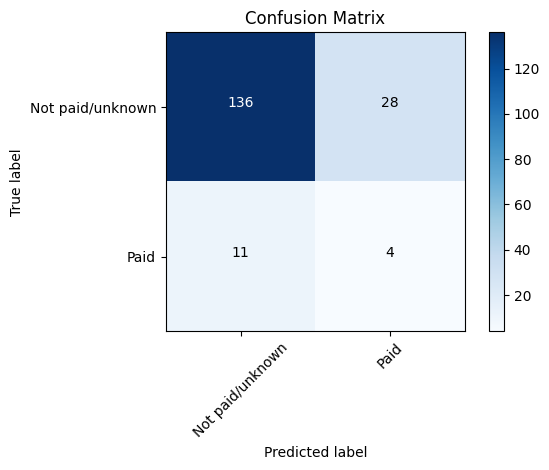

In [14]:
# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.0f'
  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, (y_test_pred > 0.5))
f1 = f1_score(y_test, (y_test_pred > 0.5))
# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5))
# Plot the confusion matrix
class_names = ['Not paid/unknown', 'Paid'] # positive class should come the last
plot_confusion_matrix(cm, class_names)

Explanations with SHAP values

Average ransom paid probability is 0.0838


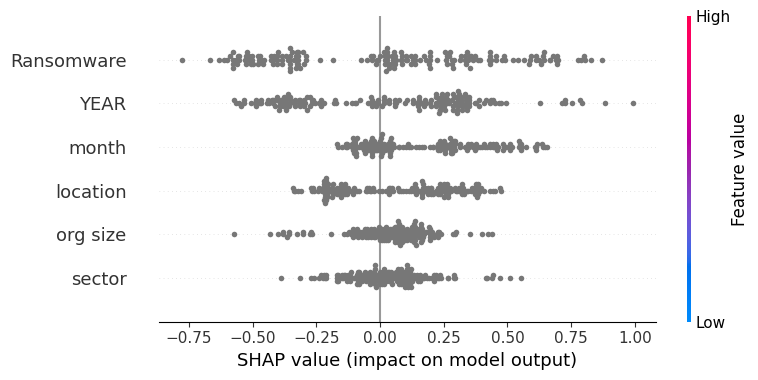

In [15]:
import shap
import numpy as np
# Install SHAP if it's not already installed
!pip install shap
# Assuming you have defined and trained your model, and X_test, y_test are defined
# model = ...
# Create a TreeExplainer for your model
ex = shap.TreeExplainer(model)
# Print the average ransom paid probability on the test set
print(f"Average ransom paid probability is {round(np.mean(y_test), 4)}")
# Compute SHAP values for your test set
shap_values = ex.shap_values(X_test)
# Generate a summary plot of the SHAP values
shap.summary_plot(shap_values, X_test, max_display=30)


sector



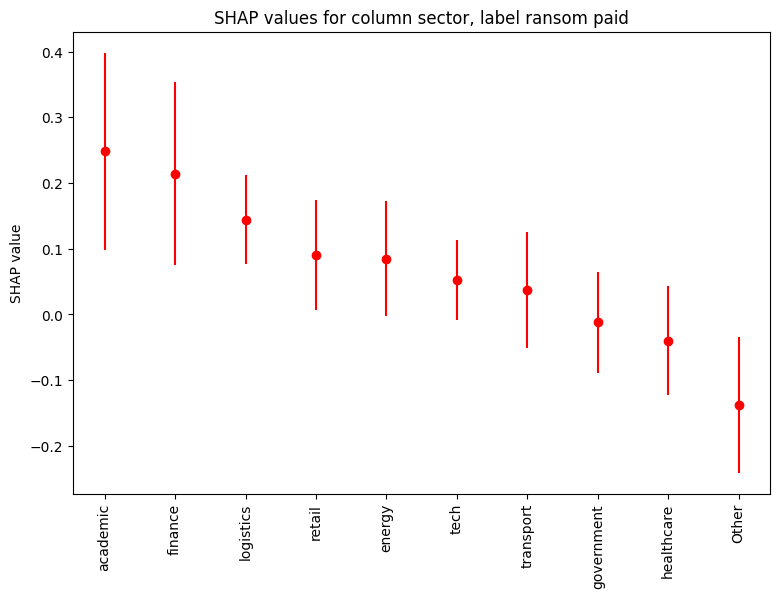

              gain  gain_std  count
col                                
academic    0.2484    0.1500     20
finance     0.2144    0.1388     11
logistics   0.1444    0.0684     11
retail      0.0907    0.0841     10
energy      0.0850    0.0871      7
tech        0.0524    0.0614     26
transport   0.0371    0.0878      5
government -0.0118    0.0766     32
healthcare -0.0400    0.0828     24
Other      -0.1375    0.1033     33

org size



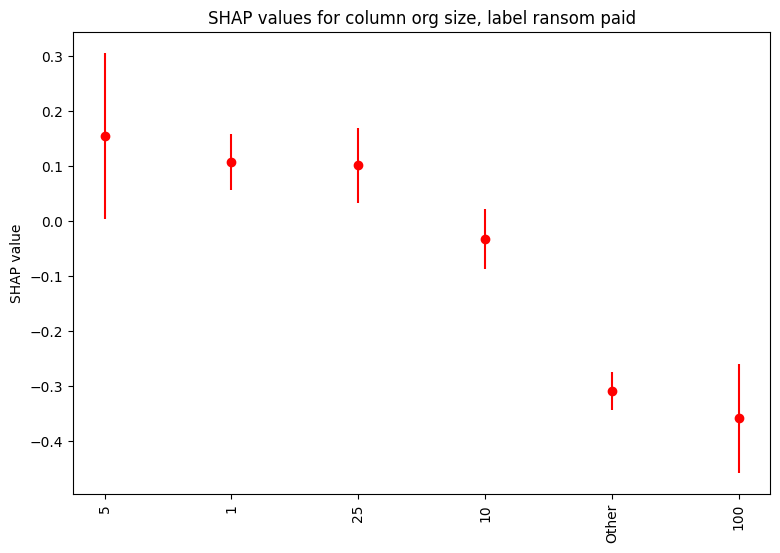

         gain  gain_std  count
col                           
5      0.1549    0.1510     28
1      0.1082    0.0510     38
25     0.1016    0.0681     48
10    -0.0331    0.0543     50
Other -0.3086    0.0343      4
100   -0.3586    0.0992     11

YEAR



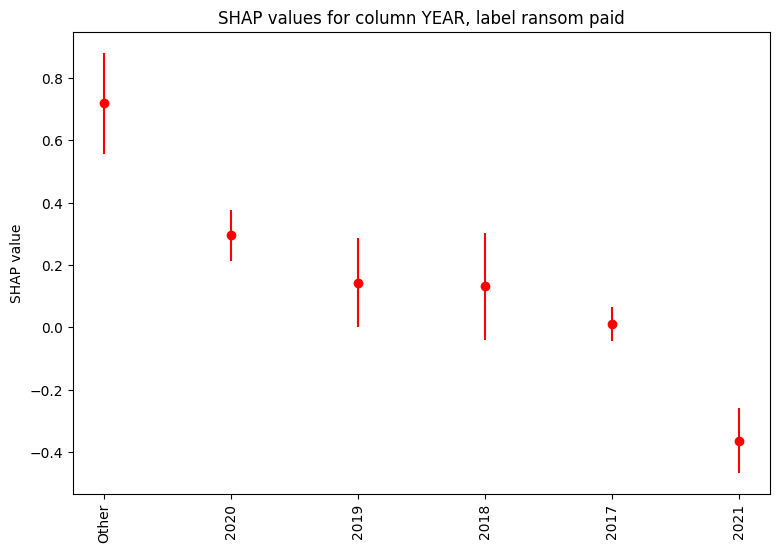

         gain  gain_std  count
col                           
Other  0.7196    0.1615     11
2020   0.2951    0.0810     60
2019   0.1438    0.1435     19
2018   0.1317    0.1713      6
2017   0.0095    0.0543     17
2021  -0.3635    0.1038     66

month



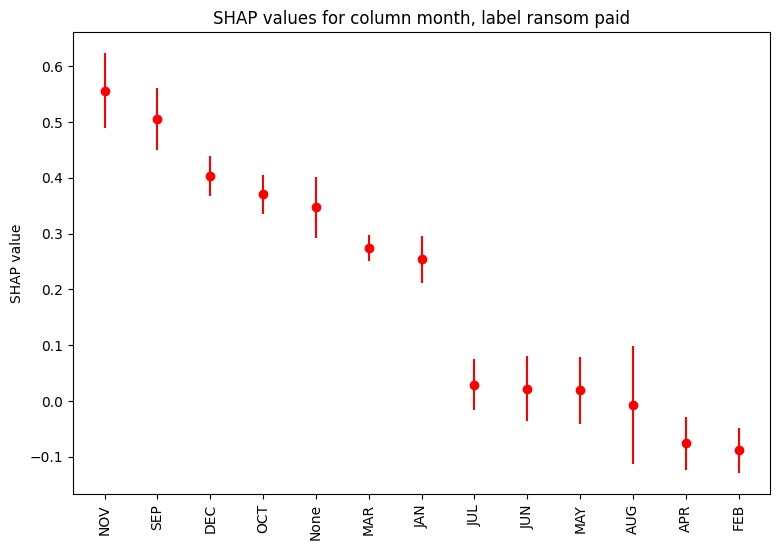

        gain  gain_std  count
col                          
NOV   0.5560    0.0674     19
SEP   0.5054    0.0555     10
DEC   0.4030    0.0365      7
OCT   0.3705    0.0350     10
None  0.3471    0.0543      3
MAR   0.2737    0.0231     19
JAN   0.2536    0.0419     17
JUL   0.0292    0.0457      4
JUN   0.0217    0.0584     22
MAY   0.0188    0.0602     25
AUG  -0.0075    0.1063      8
APR  -0.0761    0.0473     21
FEB  -0.0886    0.0408     14

location



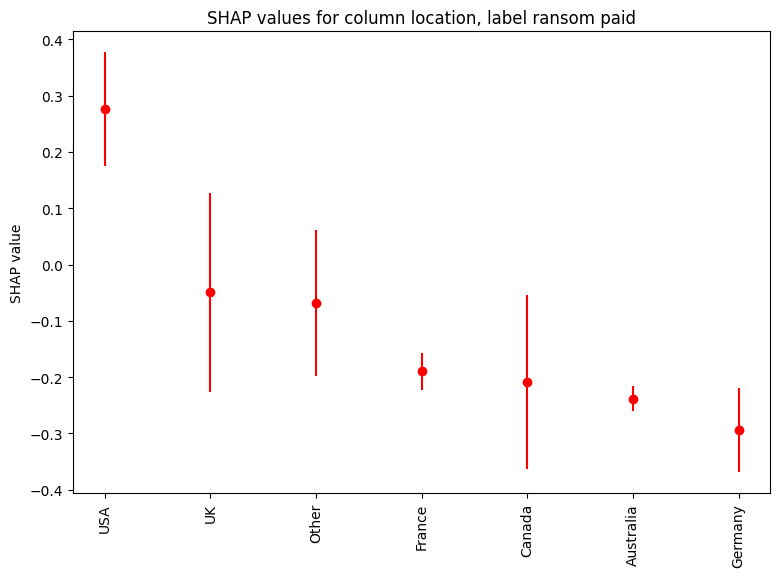

             gain  gain_std  count
col                               
USA        0.2760    0.1010     82
UK        -0.0496    0.1763     12
Other     -0.0681    0.1300     61
France    -0.1899    0.0335      7
Canada    -0.2082    0.1544      7
Australia -0.2381    0.0220      7
Germany   -0.2943    0.0750      3

Ransomware



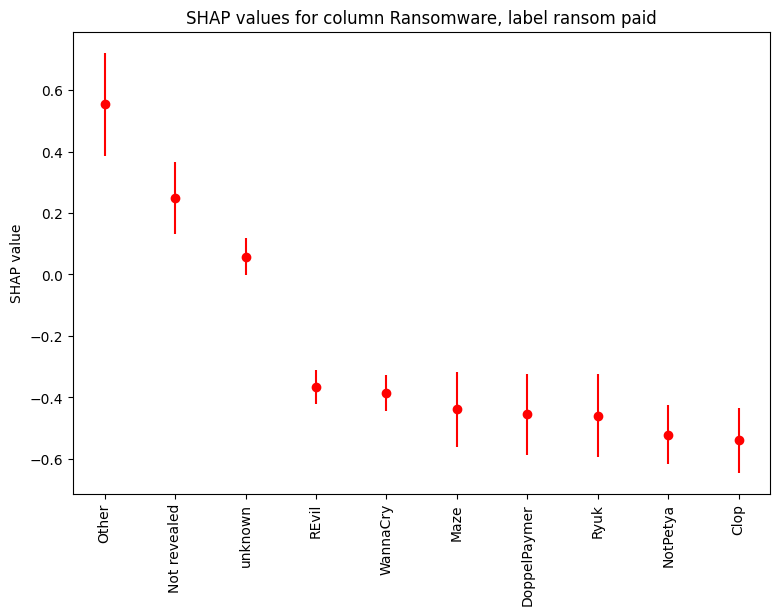

                gain  gain_std  count
col                                  
Other         0.5549    0.1676     44
Not revealed  0.2493    0.1164     26
unknown       0.0571    0.0601     40
REvil        -0.3668    0.0562     13
WannaCry     -0.3858    0.0582     12
Maze         -0.4389    0.1224      8
DoppelPaymer -0.4555    0.1319      9
Ryuk         -0.4591    0.1344     14
NotPetya     -0.5222    0.0959      6
Clop         -0.5393    0.1053      7


In [16]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='SHAP value'):
  df_infl = X_test.copy()
  df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
  gain = round(df_infl.groupby(col).mean()['shap_'],4)
  gain_std = round(df_infl.groupby(col).std()['shap_'],4)
  cnt = df_infl.groupby(col).count()['shap_']
  dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
  df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
  plt.figure(figsize=(9,6))
  plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
  plt.title(f'SHAP values for column {col}, label {label}')
  plt.ylabel(ylabel)
  plt.tick_params(axis="x", rotation=90)
  plt.show();
  print(df_res)
  return
for col in X_test.columns:
  print()
  print(col)
  print()
  show_shap(col, shap_values, label=main_label, X_test=X_test)